<a href="https://colab.research.google.com/github/SamuelKao/Predicting-NYC-taxi-destination/blob/Milestone3/WhereAreYouGoing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install holidays
!pip install openpyxl

## Import statements

In [ ]:
import pandas as pd
from datetime import datetime, date
import numpy as np
import holidays
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree


## Loading data



In [ ]:
# Assuming the file is in the current working directory
#df = pd.read_parquet('/content/drive/My Drive/CSE151GP/data/yellow_tripdata_2023-03.parquet')
#print(df.head(10))

df_list = []

file_names = [f'/content/drive/My Drive/CSE151GP/data/yellow_tripdata_2023-{month:02}.parquet' for month in range(1, 13)]

total_rows = 0

for file_name in file_names:
  try:
    df = pd.read_parquet(file_name)
    df_list.append(df)
    total_rows += df.shape[0]
  except FileNotFoundError:
    print(f"File not found: {file_name}")

print(f"Total number of rows in all files: {total_rows}")



Total number of rows in all files: 38310226


In [ ]:
# prompt: create a pandas dataframe called processing_data that contains 5% of the rows from all dfs in df_list, sample randomly.

processing_data = pd.DataFrame()
for df in df_list:
  processing_data = pd.concat([processing_data, df.sample(frac=0.001, random_state=42)])

In [ ]:
print(processing_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38311 entries, 2790731 to 13798
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               38311 non-null  int64         
 1   tpep_pickup_datetime   38311 non-null  datetime64[us]
 2   tpep_dropoff_datetime  38311 non-null  datetime64[us]
 3   passenger_count        37006 non-null  float64       
 4   trip_distance          38311 non-null  float64       
 5   RatecodeID             37006 non-null  float64       
 6   store_and_fwd_flag     37006 non-null  object        
 7   PULocationID           38311 non-null  int64         
 8   DOLocationID           38311 non-null  int64         
 9   payment_type           38311 non-null  int64         
 10  fare_amount            38311 non-null  float64       
 11  extra                  38311 non-null  float64       
 12  mta_tax                38311 non-null  float64       
 13  

## Info about data

In [ ]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [ ]:
df_list[1].describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.913955e+06,2913955,2913955,2.837138e+06,2.913955e+06,2.837138e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.913955e+06,2.837138e+06,2.837138e+06
mean,1.731282e+00,2023-02-15 00:38:01.639923,2023-02-15 00:54:02.594499,1.352847e+00,3.868058e+00,1.514554e+00,1.662570e+02,1.642317e+02,1.182896e+00,1.822038e+01,1.560472e+00,4.878752e-01,3.384825e+00,5.113983e-01,9.813052e-01,2.689848e+01,2.285299e+00,9.677754e-02
min,1.000000e+00,2008-12-31 23:05:06,2008-12-31 23:31:24,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-7.540500e+02,-7.500000e+00,-5.000000e-01,-9.300000e+01,-5.700000e+01,-1.000000e+00,-7.575500e+02,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2023-02-08 08:43:13,2023-02-08 08:59:34,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-02-14 22:33:21,2023-02-14 22:48:15,1.000000e+00,1.790000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.020000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-02-22 08:34:18,2023-02-22 08:50:06,1.000000e+00,3.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.030000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2023-03-07 13:01:28,2023-03-07 13:11:17,9.000000e+00,3.350043e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.203100e+03,2.080000e+01,4.000000e+00,4.829000e+02,1.099000e+02,1.000000e+00,2.208100e+03,2.750000e+00,1.250000e+00
std,4.524952e-01,NaN,NaN,8.891265e-01,2.684273e+02,6.633395e+00,6.413230e+01,6.975406e+01,5.297219e-01,1.749819e+01,1.792708e+00,1.006192e-01,3.838069e+00,2.024488e+00,1.873103e-01,2.184110e+01,7.609081e-01,3.388268e-01


## Checking for missing values

In [ ]:
# prompt: Can you write code that goes through all 12 dfs in df_list and counts how many missing values there are for each column
total_missing_values = 0

for i, df in enumerate(df_list):
  print(f"DataFrame {i+1}:")
  missing_counts = df.isnull().sum()
  total_missing_values += missing_counts.sum()
  print(missing_counts)
  print("-" * 25)
print(f"Total missing values: {total_missing_values}")

DataFrame 1:
VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64
-------------------------
DataFrame 2:
VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          76817
trip_distance                0
RatecodeID               76817
store_and_fwd_flag       76817
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra

## Plotting the data

In [ ]:
# in order to plot some of the data from all the different months in df_list
# a random sample is taken from every df in df_list

# prompt: randomly sample a fraction of the data in every df in df_list and combine it into a new df

def sample_and_combine(df_list, fraction=0.1):
    """Randomly samples a fraction of data from each DataFrame in a list and combines them.

    Args:
        df_list: A list of pandas DataFrames.
        fraction: The fraction of data to sample from each DataFrame (default is 0.1).

    Returns:
        A new pandas DataFrame containing the combined samples, or None if df_list is empty or invalid.
    """

    if not isinstance(df_list, list) or not all(isinstance(df, pd.DataFrame) for df in df_list):
        print("Error: Invalid input. df_list must be a list of pandas DataFrames.")
        return None

    if not df_list:
        print("Error: Empty input list.")
        return None

    sampled_dfs = []
    for df in df_list:
        try:
            sampled_df = df.sample(frac=fraction, random_state=42) # Use a consistent random state for reproducibility
            sampled_dfs.append(sampled_df)
        except ValueError as e:  # Handle cases where fraction results in less than 1 sample
            print(f"Warning: Sampling fraction resulted in an error for a DataFrame: {e}. Skipping this DataFrame.")
            continue

    if not sampled_dfs: # Check if any dataframes were sampled
        print("Warning: No DataFrames were successfully sampled.")
        return None

    combined_df = pd.concat(sampled_dfs, ignore_index=True)
    return combined_df

# Example usage (assuming df_list is defined as in your provided code):
combined_sample = sample_and_combine(df_list, fraction=0.005)

if combined_sample is not None:
    print(combined_sample.head())
    print(combined_sample.info())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-29 17:52:02   2023-01-29 17:56:43              1.0   
1         1  2023-01-08 15:57:24   2023-01-08 16:02:47              1.0   
2         2  2023-01-21 19:38:01   2023-01-21 19:45:02              1.0   
3         2  2023-01-23 16:07:31   2023-01-23 16:26:46              5.0   
4         2  2023-01-26 21:21:08   2023-01-26 21:24:48              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.17         1.0                  N           262            74   
1           0.90         1.0                  N           229           237   
2           0.95         1.0                  N            45           261   
3           0.88         1.0                  N           237           141   
4           1.03         1.0                  N           229           140   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


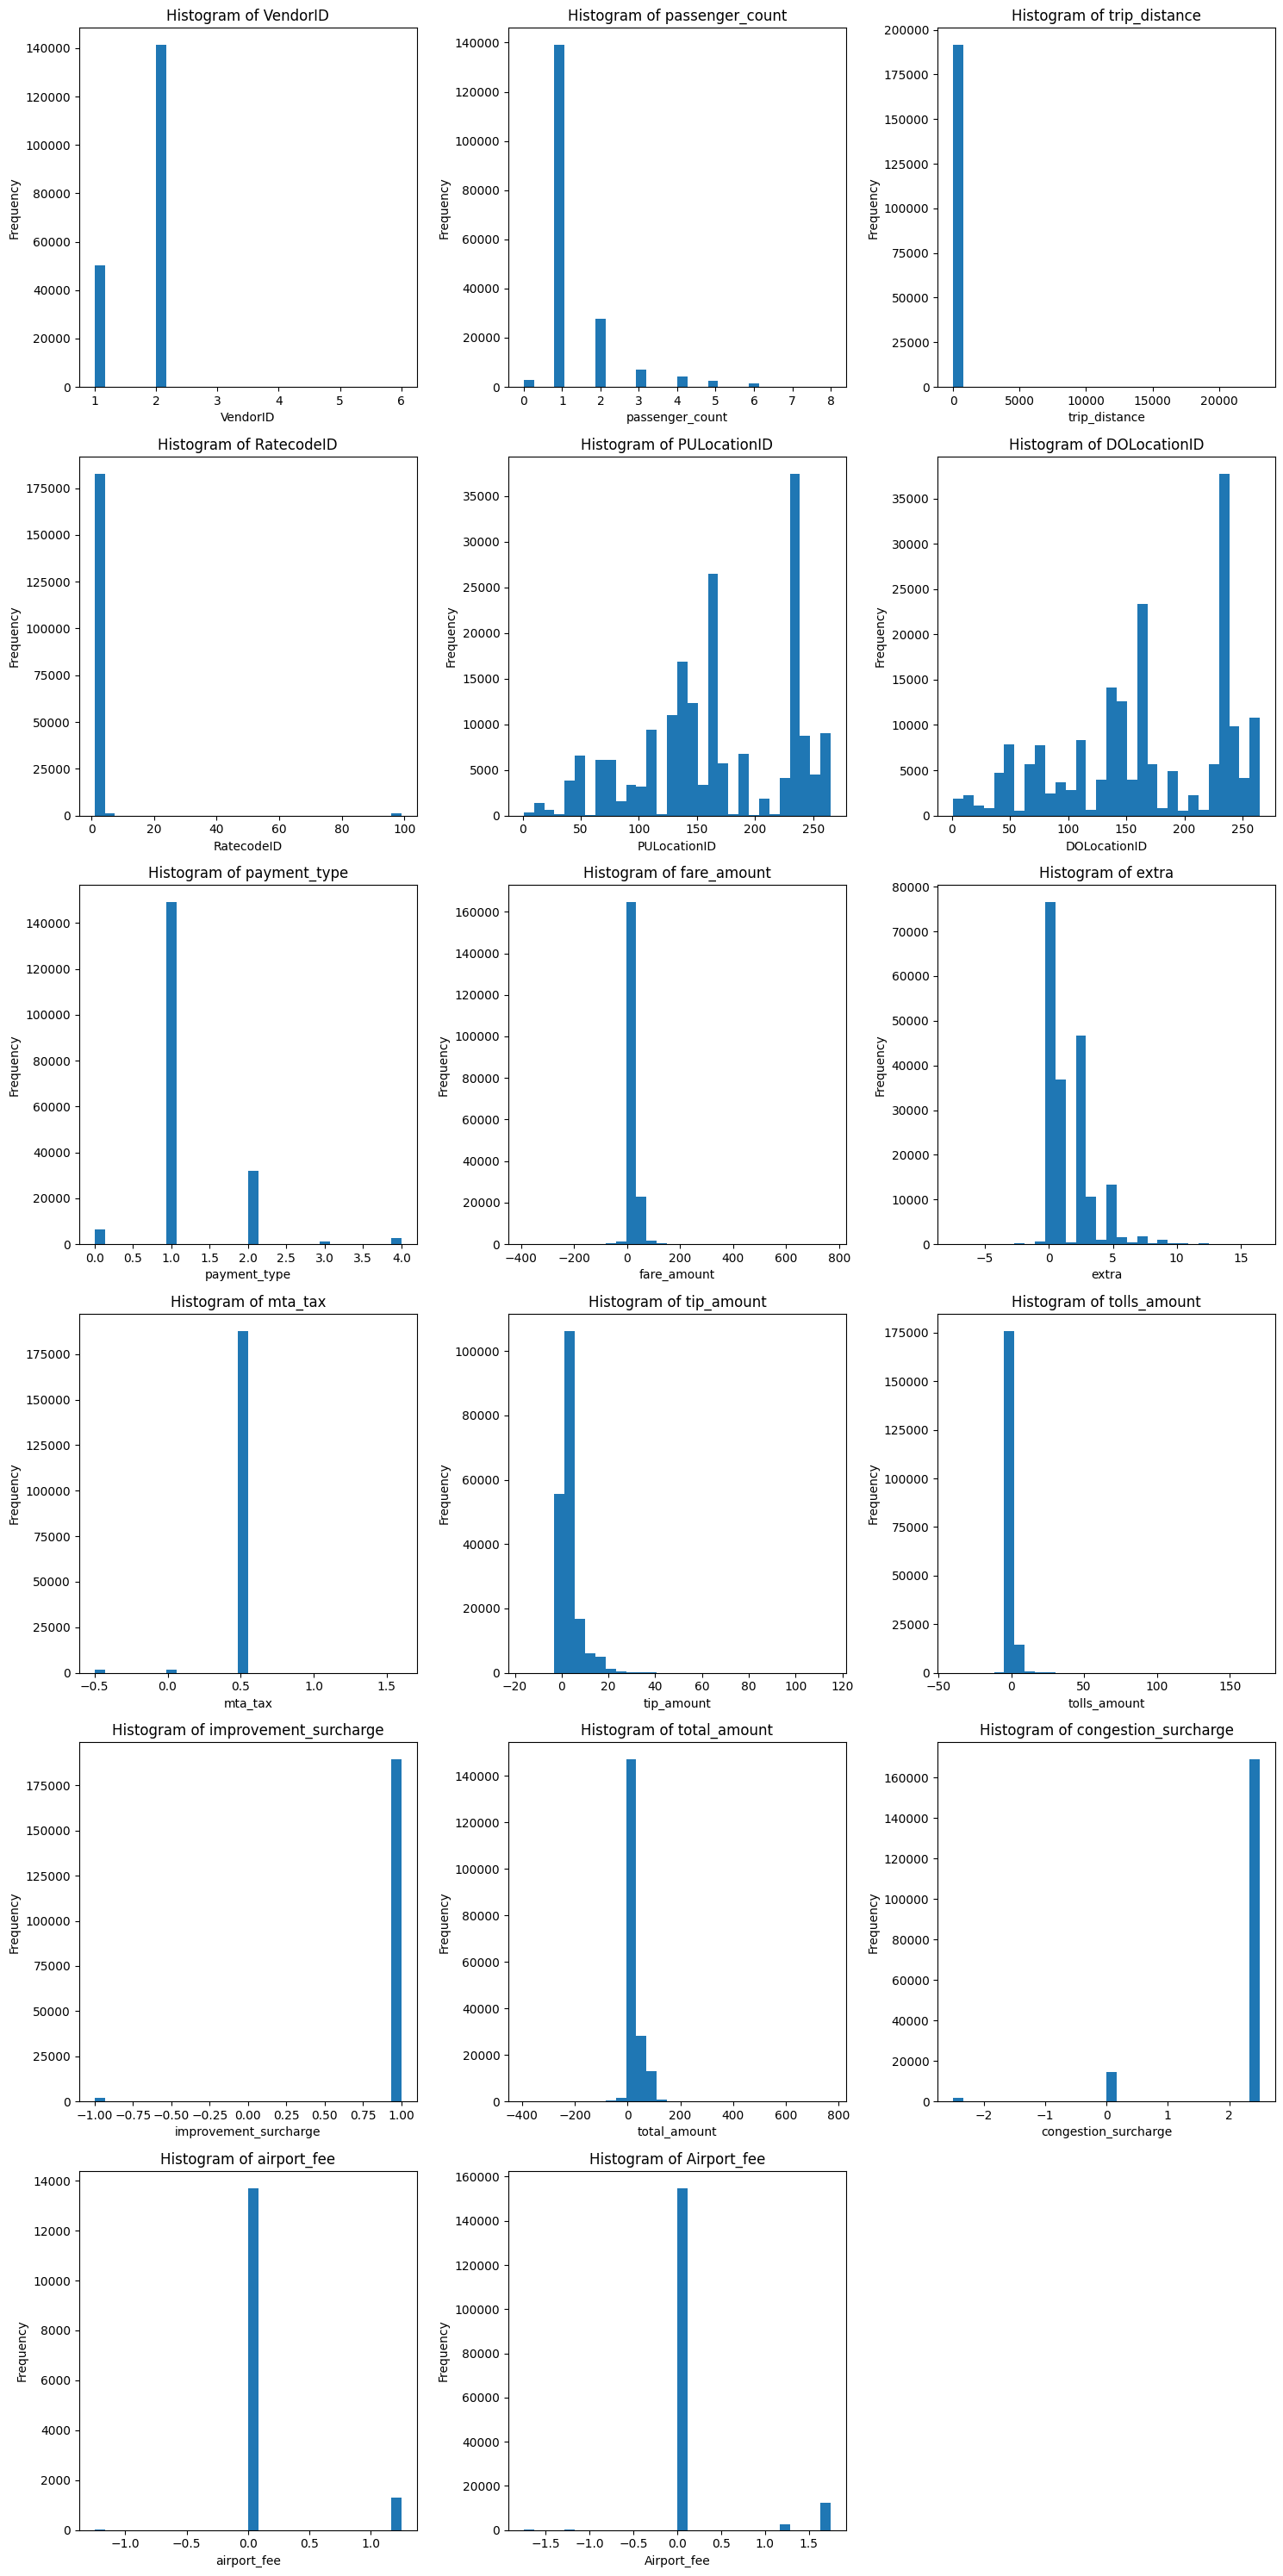

In [ ]:
# prompt: plot histograms for all the features in df in subplots


# Assuming 'df' is your DataFrame (replace with your actual DataFrame name)
# Assuming you want to plot only numerical features.
numerical_features = combined_sample.select_dtypes(include=np.number).columns

num_plots = len(numerical_features)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, feature in enumerate(numerical_features):
    if i < num_plots:
      axes[i].hist(combined_sample[feature].dropna(), bins=30) # Drop NaN values before plotting
      axes[i].set_title(f'Histogram of {feature}')
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel('Frequency')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

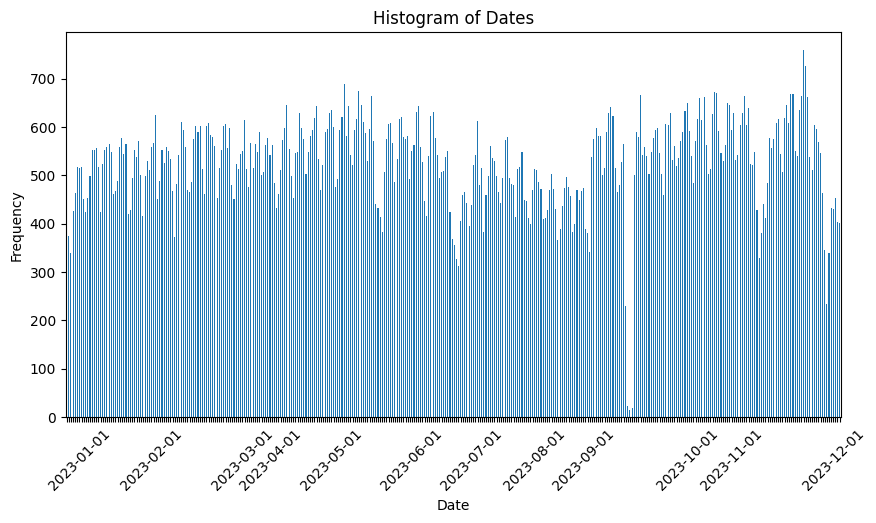

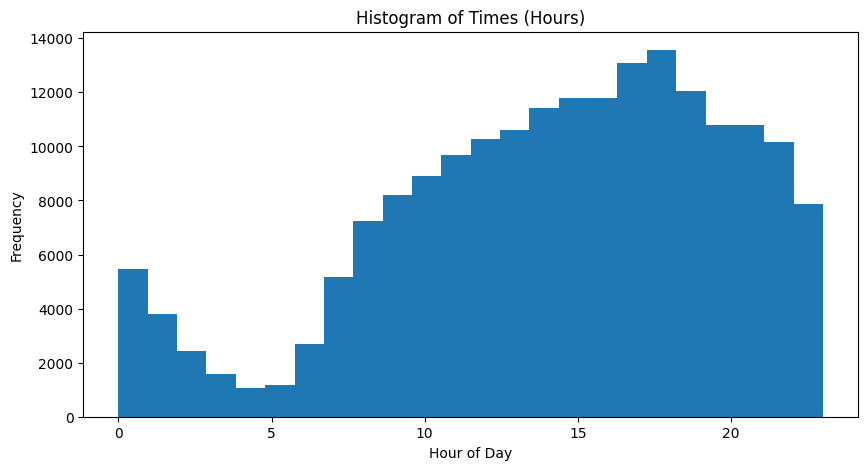

In [ ]:
# Plot histogram of dates
# Sample code to plot the histogram
plt.figure(figsize=(10, 5))
combined_sample['tpep_pickup_datetime'].dt.date.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Dates')

# Generate the list of first days of each month in the data range
date_range = combined_sample['tpep_pickup_datetime'].dt.date
first_of_month = pd.date_range(start=date_range.min(), end=date_range.max(), freq='MS').date

# Set the ticks on the x-axis to show only the first day of each month
plt.xticks(
    ticks=range(len(date_range.unique())),
    labels=[date if date in first_of_month else '' for date in date_range.unique()],
    rotation=45
)

plt.show()

# Plot histogram of times (hours) across the day
plt.figure(figsize=(10, 5))
combined_sample['tpep_pickup_datetime'].dt.hour.plot(kind='hist', bins=24)
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Histogram of Times (Hours)')
plt.show()

In [ ]:

dates_below_hundred = combined_sample['tpep_pickup_datetime'].dt.date.value_counts()
dates_below_hundred = dates_below_hundred[dates_below_hundred < 100].sort_index()

# Display the dates and their frequencies
print(dates_below_hundred)

tpep_pickup_datetime
2008-12-31     1
2023-09-22    23
2023-09-23    15
2023-09-24    18
Name: count, dtype: int64


In [ ]:
# prompt: plot scatters for combined_sample

# Assuming 'combined_sample' DataFrame is already created and available.

# Create scatter plots for numerical features against each other

# Select numerical features (excluding date/time)
numerical_cols = combined_sample.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('passenger_count')
numerical_cols.remove('trip_distance')

# Create pair plot
sns.pairplot(combined_sample[numerical_cols], diag_kind='kde')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x790f8bd4a4d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x790f8bd491b0> (for post_execute):


KeyboardInterrupt: 

## Location Encoding

In [ ]:
file_name = '/content/drive/MyDrive/CSE151GP/data/Location_ID_encoder.xlsx'
data = pd.read_excel(file_name)

In [ ]:
data.head()

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,NaN,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island


In [ ]:
# prompt: in 'data', print which LocationID is missing when it should be integers from 1 to 262

# Find missing LocationIDs
all_location_ids = set(range(1, 266))
present_location_ids = set(data['LocationID'].unique())

print(len(present_location_ids))
print("All instances of duplicated values:")
print(data['LocationID'][data['LocationID'].duplicated(keep=False)])

duplicated_rows = data[data['LocationID'].duplicated(keep=False)]
print(duplicated_rows)

missing_location_ids = all_location_ids - present_location_ids
print("Missing Location IDs:", missing_location_ids)

260
All instances of duplicated values:
55      56
56      56
103    103
104    103
105    103
Name: LocationID, dtype: int64
     OBJECTID  Shape_Leng                                           the_geom  \
55         56    0.056848  MULTIPOLYGON (((-73.85360568399982 40.74749682...   
56         57    0.019271  MULTIPOLYGON (((-73.8513110499998 40.749843375...   
103       103    0.014306  MULTIPOLYGON (((-74.04388559600675 40.69018482...   
104       104    0.021221  MULTIPOLYGON (((-74.03995040794244 40.70089063...   
105       105    0.077425  MULTIPOLYGON (((-74.01674756096064 40.69334336...   

     Shape_Area                                           zone  LocationID  \
55     0.000181                                         Corona          56   
56     0.000018                                         Corona          56   
103    0.000006  Governor's Island/Ellis Island/Liberty Island         103   
104    0.000012  Governor's Island/Ellis Island/Liberty Island         103   
105

In [ ]:
# prompt: count how many datapoints in every df in df_list that has a POlocation or DOlocation that is any of {104, 265, 105, 264, 57, 103}

def count_datapoints(df_list, locations):
    """Counts data points in each DataFrame where 'PULocationID' or 'DOLocationID' is in the specified locations.

    Args:
        df_list: A list of pandas DataFrames.
        locations: A set of location IDs to check.

    Returns:
        A dictionary where keys are DataFrame indices and values are the counts of matching data points.
    """
    counts = {}
    for i, df in enumerate(df_list):
        # Check if necessary columns exist
        if not all(col in df.columns for col in ['PULocationID', 'DOLocationID']):
            print(f"Warning: DataFrame {i} is missing 'PULocationID' or 'DOLocationID' columns. Skipping.")
            continue

        #Efficiently count matching rows using isin() and sum()
        count = df[df['PULocationID'].isin(locations) | df['DOLocationID'].isin(locations)].shape[0]
        counts[i] = count
    return counts

# Example usage:
locations_to_check = {104, 265, 105, 264, 57, 103}
datapoint_counts = count_datapoints(df_list, locations_to_check)

print(f"Total datapoints with the missing locations: {sum(datapoint_counts.values())}")

Total datapoints with the missing locations: 634440


In [ ]:
def processPickupLocation(df):
  for row in data['the_geom']:
    if type(row) == float:
      row = [0, 0]
    else:
      row = row.replace("MULTIPOLYGON", "").replace("(", "").replace(")", "").strip().split(',')

      meanCoord = []

      for pair in row:
        cords = pair.split()
        cords = [float(cords[0]), float(cords[1])]
        meanCoord.append(cords)
      meanCoord = [np.mean([x[0] for x in meanCoord]), np.mean([x[1] for x in meanCoord])]
      row = meanCoord
  data['coordx'] = row[0]
  data['coordy'] = row[1]

  new_df = df.merge(data, left_on='PULocationID', right_on='LocationID', how='inner', suffixes=('', '_PU'))
  #dfs = new_df.merge(data, left_on='DOLocationID', right_on='LocationID', how='inner', suffixes=('', '_DO')).drop(columns={'LocationID','LocationID_DO','OBJECTID','OBJECTID_DO'})
  return new_df


## Time encoding

In [ ]:
# prompt: Write a method that can read a df, pick out the coloum called tpep_pickup_datetime and read the date from this format: 2023-12-31 23:21:58 into format: number of days since year began (int), number of seconds since the day began(int), a variable indicating what day of the week it was, and one variable indicating if it was  a holiday, and which holiday it was
# Create a list of dates in 2023
dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31').to_list()
# Initialize the US holidays for 2023
us_holidays = holidays.US(years=2023)
print(us_holidays)

{datetime.date(2023, 1, 1): "New Year's Day", datetime.date(2023, 1, 2): "New Year's Day (observed)", datetime.date(2023, 5, 29): 'Memorial Day', datetime.date(2023, 6, 19): 'Juneteenth National Independence Day', datetime.date(2023, 7, 4): 'Independence Day', datetime.date(2023, 9, 4): 'Labor Day', datetime.date(2023, 11, 11): 'Veterans Day', datetime.date(2023, 11, 10): 'Veterans Day (observed)', datetime.date(2023, 11, 23): 'Thanksgiving', datetime.date(2023, 12, 25): 'Christmas Day', datetime.date(2023, 1, 16): 'Martin Luther King Jr. Day', datetime.date(2023, 2, 20): "Washington's Birthday", datetime.date(2023, 10, 9): 'Columbus Day'}


In [ ]:
# Create a dictionary to store holiday information
holiday_dict = {}
for date in dates_2023:
   if date in us_holidays:
       holiday_dict[date] = us_holidays.get(date)
holiday_dict

{Timestamp('2023-01-01 00:00:00'): "New Year's Day",
 Timestamp('2023-01-02 00:00:00'): "New Year's Day (observed)",
 Timestamp('2023-01-16 00:00:00'): 'Martin Luther King Jr. Day',
 Timestamp('2023-02-20 00:00:00'): "Washington's Birthday",
 Timestamp('2023-05-29 00:00:00'): 'Memorial Day',
 Timestamp('2023-06-19 00:00:00'): 'Juneteenth National Independence Day',
 Timestamp('2023-07-04 00:00:00'): 'Independence Day',
 Timestamp('2023-09-04 00:00:00'): 'Labor Day',
 Timestamp('2023-10-09 00:00:00'): 'Columbus Day',
 Timestamp('2023-11-10 00:00:00'): 'Veterans Day (observed)',
 Timestamp('2023-11-11 00:00:00'): 'Veterans Day',
 Timestamp('2023-11-23 00:00:00'): 'Thanksgiving',
 Timestamp('2023-12-25 00:00:00'): 'Christmas Day'}

In [ ]:
def process_datetime(df):
  # Check if the 'tpep_pickup_datetime' column exists
  if 'tpep_pickup_datetime' not in df.columns:
    print("Error: 'tpep_pickup_datetime' column not found in DataFrame.")
    return df


  #Check if the coloumn is in datetime format:
  if not pd.api.types.is_datetime64_any_dtype(df['tpep_pickup_datetime']):
    print("Potential Error: 'tpep_pickup_datetime' column is not in datetime format.")
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])




  # Extract year from the datetime column
  df['year'] = df['tpep_pickup_datetime'].dt.year


  # Calculate the number of days since the year began
  df['sine_days_since_year_began'] = np.sin((df['tpep_pickup_datetime'].dt.dayofyear - 1)*2*np.pi/364)
  df['cosine_days_since_year_began'] = np.cos((df['tpep_pickup_datetime'].dt.dayofyear - 1)*2*np.pi/364)




  # Calculate the number of seconds since the day began
  df['sine_seconds_since_day_began'] = np.sin((df['tpep_pickup_datetime'].dt.second + \
                                  df['tpep_pickup_datetime'].dt.minute * 60 + \
                                  df['tpep_pickup_datetime'].dt.hour * 3600)*2*np.pi/86400)
  df['cos_seconds_since_day_began'] = np.cos((df['tpep_pickup_datetime'].dt.second + \
                                  df['tpep_pickup_datetime'].dt.minute * 60 + \
                                  df['tpep_pickup_datetime'].dt.hour * 3600)*2*np.pi/86400)


  # Get the day of the week (Monday=0, Sunday=6)
  df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek


  # Initialize US holidays for the year of the data
  year = df['tpep_pickup_datetime'].dt.year.iloc[0]  # Get the year from the data
  us_holidays = holidays.US(years=year)
  holiday_set = set(us_holidays.keys())
  # Create holiday columns
  current_date = df['tpep_pickup_datetime'].dt.date

  df['holiday_today'] = current_date.where(current_date.isin(holiday_set), None).map(lambda x: 1 if x is not None else 0)

  df['DateOffset'] = pd.DateOffset(days=1)

  df['day_after_holiday'] = current_date - pd.DateOffset(days=1)

  df['holiday_yesterday'] =df['day_after_holiday'].apply(lambda date: 1 if date in us_holidays else 0)

  df['day_before_holiday'] = current_date + df['DateOffset']

  df['holiday_tomorrow'] = df['day_before_holiday'].apply(lambda date: 1 if date in us_holidays else 0)
  # lambda if we want the holiday as the input "lambda date: us_holidays.get(date) if date in us_holidays else None"




  return df


In [ ]:
#test_df = df_list[0].head(10).copy()
test_df = df_list[11].tail(10).copy()
#test_df = df_list[0].sample(n=25, random_state=22).copy()
processed_df_test = process_datetime(test_df)


processed_df_test

1
2
3
4
5
6


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,cosine_days_since_year_began,sine_seconds_since_day_began,cos_seconds_since_day_began,day_of_week,holiday_today,DateOffset,day_after_holiday,holiday_yesterday,day_before_holiday,holiday_tomorrow
3376557,2,2023-12-31 23:30:29,2023-12-31 23:36:25,NaN,1.17,NaN,None,116,244,0,...,1.0,-0.128435,0.991718,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376558,2,2023-12-31 23:40:19,2024-01-01 00:21:49,NaN,21.62,NaN,None,86,162,0,...,1.0,-0.085779,0.996314,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376559,2,2023-12-31 23:15:42,2023-12-31 23:28:44,NaN,6.04,NaN,None,132,219,0,...,1.0,-0.192094,0.981377,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376560,2,2023-12-31 23:33:26,2023-12-31 23:52:51,NaN,3.38,NaN,None,76,39,0,...,1.0,-0.115660,0.993289,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376561,2,2023-12-31 23:07:09,2023-12-31 23:26:47,NaN,3.78,NaN,None,61,124,0,...,1.0,-0.228563,0.973529,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376562,2,2023-12-31 23:04:34,2023-12-31 23:13:58,NaN,1.34,NaN,None,233,163,0,...,1.0,-0.239522,0.970891,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376563,2,2023-12-31 23:08:15,2023-12-31 23:08:23,NaN,0.00,NaN,None,48,48,0,...,1.0,-0.223888,0.974615,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376564,2,2023-12-31 23:16:15,2023-12-31 23:30:28,NaN,3.71,NaN,None,196,198,0,...,1.0,-0.189738,0.981835,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376565,2,2023-12-31 23:21:58,2023-12-31 23:34:29,NaN,5.20,NaN,None,140,148,0,...,1.0,-0.165191,0.986262,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1
3376566,2,2023-12-31 23:10:47,2023-12-31 23:27:58,NaN,6.81,NaN,None,237,261,0,...,1.0,-0.213101,0.977030,6,0,<DateOffset: days=1>,2023-12-30 00:00:00,0,2024-01-01 00:00:00,1


## Training first network

In [ ]:
median_passenger = processing_data['passenger_count'].median()
processing_data['passenger_count'] = processing_data['passenger_count'].fillna(median_passenger).mask(processing_data['passenger_count'] ==0 , median_passenger)
processing_data  = processPickupLocation(processing_data)
process_datetime(processing_data)

1
2
3
4
5
6


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,cosine_days_since_year_began,sine_seconds_since_day_began,cos_seconds_since_day_began,day_of_week,holiday_today,DateOffset,day_after_holiday,holiday_yesterday,day_before_holiday,holiday_tomorrow
0,2,2023-01-29 17:52:02,2023-01-29 17:56:43,1.0,1.17,1.0,N,262,74,2,...,0.885456,-0.999396,-0.034754,6,0,<DateOffset: days=1>,2023-01-28 00:00:00,0,2023-01-30 00:00:00,0
1,1,2023-01-08 15:57:24,2023-01-08 16:02:47,1.0,0.90,1.0,N,229,237,2,...,0.992709,-0.860297,-0.509792,6,0,<DateOffset: days=1>,2023-01-07 00:00:00,0,2023-01-09 00:00:00,0
2,2,2023-01-21 19:38:01,2023-01-21 19:45:02,1.0,0.95,1.0,N,45,261,1,...,0.940998,-0.909931,0.414759,5,0,<DateOffset: days=1>,2023-01-20 00:00:00,0,2023-01-22 00:00:00,0
3,2,2023-01-23 16:07:31,2023-01-23 16:26:46,5.0,0.88,1.0,N,237,141,1,...,0.928756,-0.881956,-0.471333,0,0,<DateOffset: days=1>,2023-01-22 00:00:00,0,2023-01-24 00:00:00,0
4,2,2023-01-26 21:21:08,2023-01-26 21:24:48,2.0,1.03,1.0,N,229,140,1,...,0.908324,-0.638992,0.769214,3,0,<DateOffset: days=1>,2023-01-25 00:00:00,0,2023-01-27 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37913,2,2023-12-16 21:57:31,2023-12-16 22:28:56,1.0,1.91,1.0,N,43,170,1,...,0.966666,-0.509354,0.860557,5,0,<DateOffset: days=1>,2023-12-15 00:00:00,0,2023-12-17 00:00:00,0
37914,2,2023-12-05 14:09:10,2023-12-05 14:22:16,1.0,0.99,1.0,N,263,140,3,...,0.900969,-0.534229,-0.845340,1,0,<DateOffset: days=1>,2023-12-04 00:00:00,0,2023-12-06 00:00:00,0
37915,2,2023-12-14 09:14:26,2023-12-14 09:19:37,1.0,0.55,1.0,N,148,114,2,...,0.957253,0.661203,-0.750207,3,0,<DateOffset: days=1>,2023-12-13 00:00:00,0,2023-12-15 00:00:00,0
37916,2,2023-12-24 12:20:36,2023-12-24 12:53:43,1.0,15.20,2.0,N,237,132,2,...,0.992709,-0.089763,-0.995963,6,0,<DateOffset: days=1>,2023-12-23 00:00:00,0,2023-12-25 00:00:00,1


In [ ]:
train_df, test_df = train_test_split(processing_data, test_size = 0.2,random_state = 42)

In [ ]:
# prompt: print allt the columns of processing_data

processing_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Airport_fee',
       'OBJECTID', 'Shape_Leng', 'the_geom', 'Shape_Area', 'zone',
       'LocationID', 'borough', 'coordx', 'coordy', 'year',
       'sine_days_since_year_began', 'cosine_days_since_year_began',
       'sine_seconds_since_day_began', 'cos_seconds_since_day_began',
       'day_of_week', 'holiday_today', 'DateOffset', 'day_after_holiday',
       'holiday_yesterday', 'day_before_holiday', 'holiday_tomorrow'],
      dtype='object')

In [ ]:
X_train = train_df[['sine_days_since_year_began', 'cosine_days_since_year_began',
       'sine_seconds_since_day_began', 'cos_seconds_since_day_began',
       'day_of_week', 'holiday_today',
       'holiday_yesterday', 'holiday_tomorrow', 'coordx', 'coordy']]
y_train = train_df['PULocationID']
X_test = test_df[['sine_days_since_year_began', 'cosine_days_since_year_began',
       'sine_seconds_since_day_began', 'cos_seconds_since_day_began',
       'day_of_week', 'holiday_today',
       'holiday_yesterday', 'holiday_tomorrow',  'coordx', 'coordy']]
y_test = test_df['DOLocationID']

In [ ]:
# prompt: one hot encode y_test to create a y_test_encoded

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.values.reshape(-1, 1))
y_test_encoded = enc.transform(y_test.values.reshape(-1, 1)).toarray()
y_train_encoded = enc.transform(y_train.values.reshape(-1, 1)).toarray()

In [ ]:
# prompt: write a multinomial logistic regression to predict a one hot encoded y predictor

from sklearn.linear_model import LogisticRegression

# Initialize and train the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500) # Increased max_iter
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.0357331223628692


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
probabilities = model.predict_proba(X_test)
top_5_indices = np.argsort(probabilities, axis=1)[:, -5:]
is_correct = np.isin(y_test, top_5_indices)  # Assuming y_test is a single-column format
accuracy = np.mean(is_correct)
print(f"Top-5 Accuracy: {accuracy}")



Top-5 Accuracy: 0.1238132911392405


In [ ]:
probabilities = model.predict_proba(X_train)
top_5_indices = np.argsort(probabilities, axis=1)[:, -5:]
is_correct = np.isin(y_train, top_5_indices)  # Assuming y_test is a single-column format
accuracy = np.mean(is_correct)
print(f"Top-5 Accuracy: {accuracy}")



Top-5 Accuracy: 0.14007384453088942


In [ ]:
%%capture
iters = [5, 10, 50, 100, 500]
MSEs = []
train_MSEs = []
for iter in iters:
  # Initialize and train the multinomial logistic regression model
  short_trained_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iter) # Increased max_iter
  short_trained_model.fit(X_train, y_train)


  # Make predictions on the test set
  y_pred = short_trained_model.predict(X_test)

  mse = np.mean(np.sum((y_test_encoded - short_trained_model.predict_proba(X_test))**2, axis=1))

  MSEs.append(mse)
  train_mse = np.mean(np.sum((y_train_encoded - short_trained_model.predict_proba(X_train))**2, axis=1))
  train_MSEs.append(train_mse)


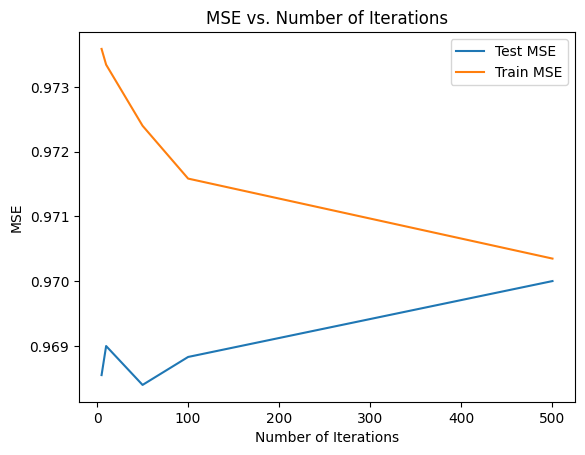

In [ ]:
plt.plot(iters, MSEs)
plt.plot(iters, train_MSEs)
plt.xlabel('Number of Iterations')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Iterations')
plt.legend(['Test MSE', 'Train MSE'])
plt.show()